# Problem 4 - Batch Normalization, Dropout, MNIST

## 4.1

**Answer:**

- *co-adaptation*: refers to a scenario in neural networks where some parameters or neurons adjust to correct the errors introduced by other neurons instead of learning the actual underlying representation. This dependency can lead to overfitting, as these neurons become tightly coupled and rely on the specific noise/structure of the training data. Dropout is a technique that helps break these co-adaptations by randomly turning off neurons (making their output zero), forcing the network to distribute learning and become more robust.

- *covariance-shift*: refers to the phenomenon during training where the distribution of the inputs to each layer changes as the parameters of the previous layers change. This constant shift slows down the training because each layer needs to continuously adapt to the new input distribution. Batch Normalization addresses this by standardizing the inputs to each layer, reducing the amount of shift, and allowing for higher learning rates and faster convergence.

## 4.2

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, BatchNormalization, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist

# Load and preprocess data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255 # standard normalization
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

# Define LeNet-5 model
model = Sequential([
    InputLayer(input_shape=(28, 28, 1)),
    Conv2D(6, (5, 5), activation='tanh'),
    AveragePooling2D(),
    BatchNormalization(),
    Conv2D(16, (5, 5), activation='tanh'),
    AveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(120, activation='tanh'),
    BatchNormalization(),
    Dense(84, activation='tanh'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

# Compile and train the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=10, batch_size=128, validation_data=(test_images, test_labels))

Epoch 1/10
469/469 [==============================] - 27s 55ms/step - loss: 0.4141 - accuracy: 0.8840 - val_loss: 0.2472 - val_accuracy: 0.9328
Epoch 2/10
469/469 [==============================] - 24s 52ms/step - loss: 0.2177 - accuracy: 0.9385 - val_loss: 0.1781 - val_accuracy: 0.9513
Epoch 3/10
469/469 [==============================] - 24s 52ms/step - loss: 0.1661 - accuracy: 0.9532 - val_loss: 0.1375 - val_accuracy: 0.9625
Epoch 4/10
469/469 [==============================] - 25s 53ms/step - loss: 0.1349 - accuracy: 0.9622 - val_loss: 0.1161 - val_accuracy: 0.9659
Epoch 5/10
469/469 [==============================] - 24s 52ms/step - loss: 0.1130 - accuracy: 0.9682 - val_loss: 0.0999 - val_accuracy: 0.9709
Epoch 6/10
469/469 [==============================] - 25s 54ms/step - loss: 0.0995 - accuracy: 0.9715 - val_loss: 0.0865 - val_accuracy: 0.9741
Epoch 7/10
469/469 [==============================] - 24s 52ms/step - loss: 0.0878 - accuracy: 0.9746 - val_loss: 0.0799 - val_accuracy:

In [4]:
# Extract gamma (scale) and beta (offset) from BatchNormalization layers
gammas, betas = [], []

for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        gammas.append(layer.get_weights()[0])  # gamma/scale
        betas.append(layer.get_weights()[1])   # beta/offset

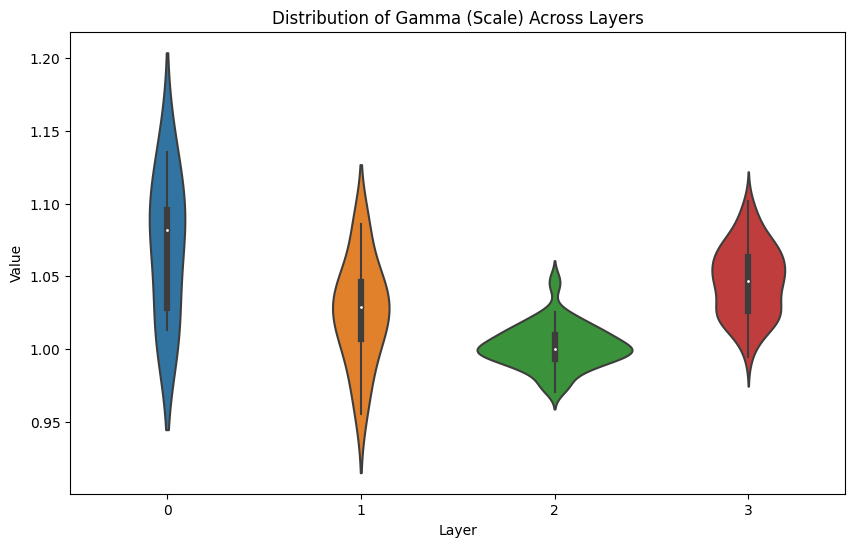

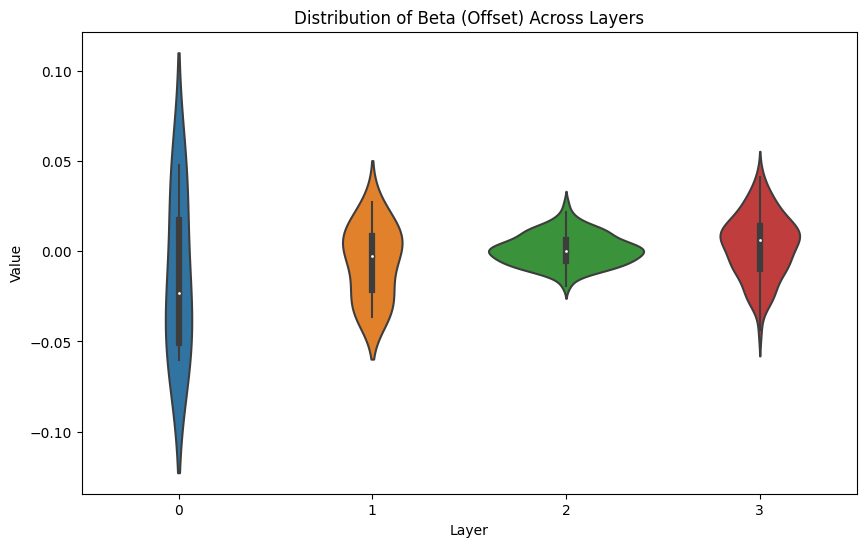

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_violin(data, title):
    plt.figure(figsize=(10,6))
    sns.violinplot(data=data)
    plt.title(title)
    plt.xlabel('Layer')
    plt.ylabel('Value')
    plt.show()

# Plot for each parameter
plot_violin(gammas, "Distribution of Gamma (Scale) Across Layers")
plot_violin(betas, "Distribution of Beta (Offset) Across Layers")

In [6]:
layer_num = 1
for layer in model.layers:
    if isinstance(layer, BatchNormalization):
        # Retrieve the parameters from the batch normalization layer
        gamma, beta = layer.get_weights()[:2]  # gamma is scale, beta is shift

        print(f"Batch Normalization Layer {layer_num}:")
        print(f"Gamma (scale): {gamma}")
        print(f"Beta (shift): {beta}\n")
        layer_num +=1

Batch Normalization Layer 1:
Gamma (scale): [1.0909592 1.0128596 1.072521  1.1354426 1.0966874 1.0136129]
Beta (shift): [ 0.02794624  0.04781232 -0.01432584 -0.03164781 -0.06050827 -0.05723814]

Batch Normalization Layer 2:
Gamma (scale): [1.0494905 1.0862052 1.0277513 1.0529126 0.9772443 1.0193237 1.0072609
 1.0452582 1.0129409 1.0295278 0.9557067 1.0056822 1.0327516 1.0363783
 1.0835533 0.9855784]
Beta (shift): [ 0.01450038 -0.02540988 -0.03632792 -0.02045732 -0.00539335  0.00485741
  0.01508876 -0.03293907 -0.00621822 -0.03658305  0.00040846  0.02708133
 -0.02006936  0.01387884  0.00652644  0.00308238]

Batch Normalization Layer 3:
Gamma (scale): [1.0053507  0.9721519  0.99594754 1.0115777  1.0039989  0.999102
 0.9731676  0.99243695 0.995565   0.9987475  1.0145174  1.0484241
 0.99991083 0.9984323  0.9869378  1.0251585  1.0426878  1.0117018
 0.99867004 0.98547524 1.0231247  1.0032179  1.0002785  0.98556876
 0.9923601  1.0222709  1.0119864  0.9769501  0.981665   1.0056567
 0.9959236  

- The beta values, which are the offsets, seem to be centered around zero for most layers. This means the BN layers are making small shifts to the activations.
- On the other hand, the gamma values are centered around 1 for most layers. This indicates that the BN layers aren't drastically scaling up or down the activations. However, Layer 0 has values predominantly above 1, suggesting a slightly more pronounced scaling in this layer.

Overall, the gamma values are centered around 1 for the provided layers, which is expected for a well-trained model. Beta values, however, are closer to 0, indicating minimal offset, which is also typical for batch normalization after training.

## 4.3

In [7]:
# Modified model with BatchNormalization after the input layer
model_batch_norm = Sequential([
    BatchNormalization(input_shape=(28, 28, 1)),
    Conv2D(6, (5, 5), activation='tanh'),
    AveragePooling2D(),
    BatchNormalization(),
    Conv2D(16, (5, 5), activation='tanh'),
    AveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(120, activation='tanh'),
    BatchNormalization(),
    Dense(84, activation='tanh'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

In [8]:
# Compile original and input model
optimizer = 'sgd'
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model_batch_norm.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train original and input model
epochs = 10
batch_size = 128

history_batch_norm = model_batch_norm.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels))

Epoch 1/10
469/469 [==============================] - 35s 72ms/step - loss: 0.3773 - accuracy: 0.8923 - val_loss: 0.1738 - val_accuracy: 0.9528
Epoch 2/10
469/469 [==============================] - 32s 68ms/step - loss: 0.1496 - accuracy: 0.9590 - val_loss: 0.1056 - val_accuracy: 0.9711
Epoch 3/10
469/469 [==============================] - 33s 71ms/step - loss: 0.1057 - accuracy: 0.9710 - val_loss: 0.0841 - val_accuracy: 0.9765
Epoch 4/10
469/469 [==============================] - 36s 78ms/step - loss: 0.0862 - accuracy: 0.9759 - val_loss: 0.0725 - val_accuracy: 0.9794
Epoch 5/10
469/469 [==============================] - 32s 68ms/step - loss: 0.0746 - accuracy: 0.9789 - val_loss: 0.0651 - val_accuracy: 0.9817
Epoch 6/10
469/469 [==============================] - 34s 72ms/step - loss: 0.0671 - accuracy: 0.9807 - val_loss: 0.0579 - val_accuracy: 0.9836
Epoch 7/10
469/469 [==============================] - 31s 67ms/step - loss: 0.0607 - accuracy: 0.9828 - val_loss: 0.0536 - val_accuracy:

<ipython-input-16-d22cae3d1944>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


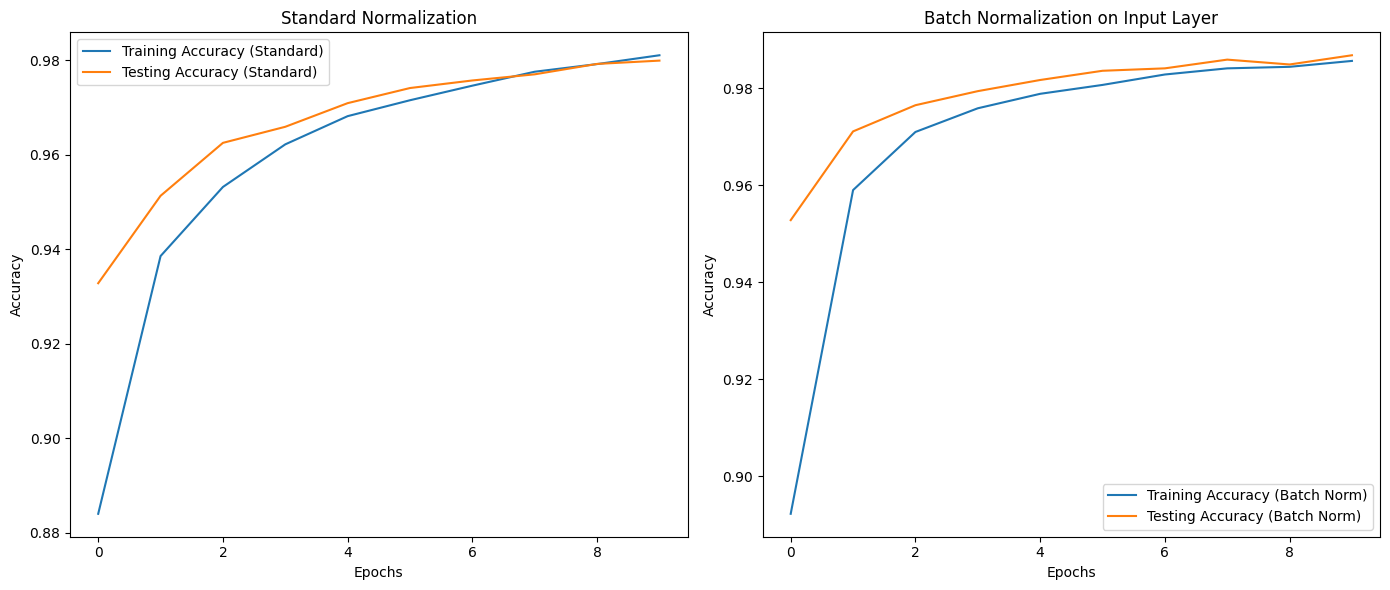

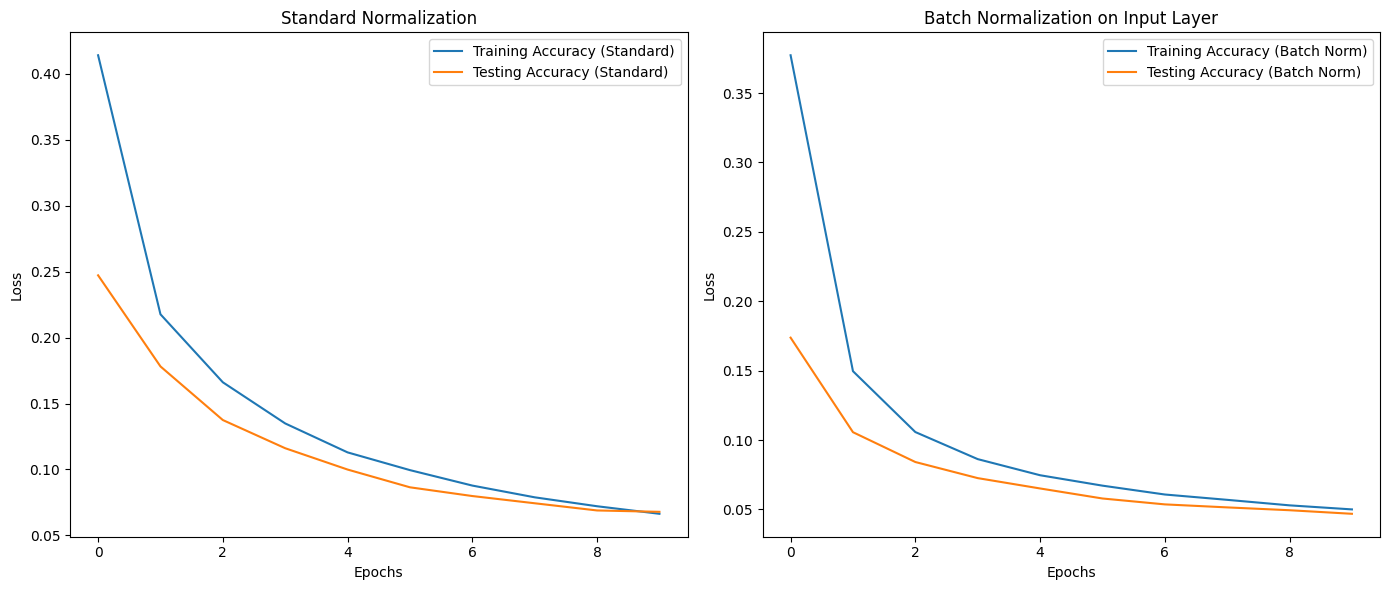

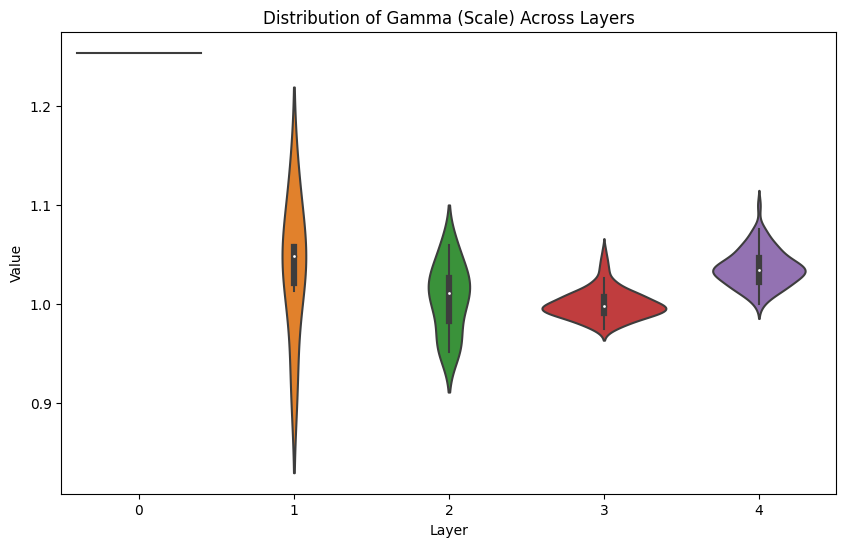

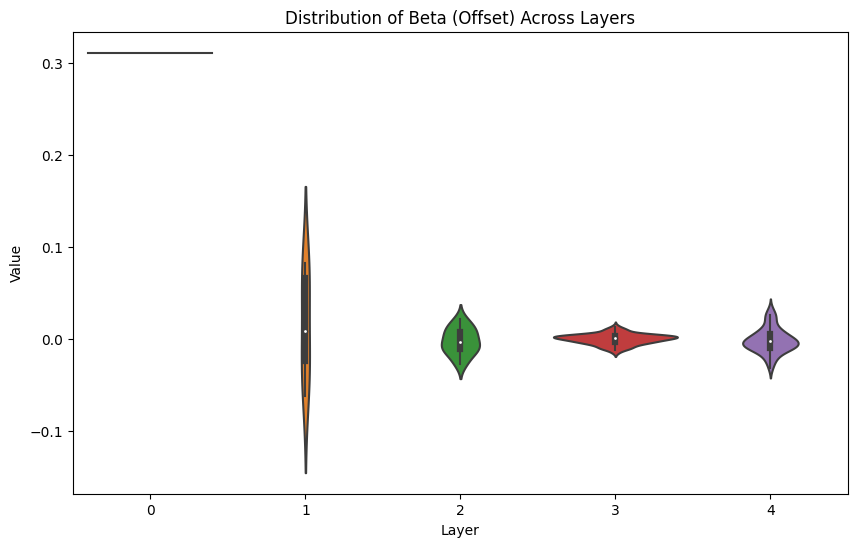

In [16]:
plt.figure(figsize=(14, 6))
plt.ylim(0.8, 1)
# Plotting for Standard Normalization (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy (Standard)')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy (Standard)')
plt.title('Standard Normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting for Batch Normalization on Input Layer (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history_batch_norm.history['accuracy'], label='Training Accuracy (Batch Norm)')
plt.plot(history_batch_norm.history['val_accuracy'], label='Testing Accuracy (Batch Norm)')
plt.title('Batch Normalization on Input Layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

# Plotting for Standard Normalization (Loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Accuracy (Standard)')
plt.plot(history.history['val_loss'], label='Testing Accuracy (Standard)')
plt.title('Standard Normalization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting for Batch Normalization on Input Layer (Loss)
plt.subplot(1, 2, 2)
plt.plot(history_batch_norm.history['loss'], label='Training Accuracy (Batch Norm)')
plt.plot(history_batch_norm.history['val_loss'], label='Testing Accuracy (Batch Norm)')
plt.title('Batch Normalization on Input Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Extract gamma (scale) and beta (offset) from BatchNormalization layers
gammas, betas = [], []

for layer in model_batch_norm.layers:
    if isinstance(layer, BatchNormalization):
        gammas.append(layer.get_weights()[0])  # gamma/scale
        betas.append(layer.get_weights()[1])   # beta/offset

# Extract Batch Normalization weights and plot violin plots
plot_violin(gammas, "Distribution of Gamma (Scale) Across Layers")
plot_violin(betas, "Distribution of Beta (Offset) Across Layers")

**Answer:**

**1) Model Accuracy:**
- For both the standard and batch normalization (BN) methods, the training accuracy seems to be higher than the testing accuracy. The difference in accuracy indicates potential overfitting, especially for the standard method.
- Both standard and BN methods achieve high training accuracy. However, the BN method achieves slightly higher testing accuracy than the standard method by the end of training.

**2) Model Loss:**
- The loss for both training and testing datasets is lower for the BN method compared to the standard method. A lower loss generally indicates better performance.
- The testing loss for the BN method appears to be more stable and consistently decreases, whereas the testing loss for the standard method shows a bit of volatility, indicating potential overfitting or less stable training.

**3) Training and Testing Accuracy Comparison (with and without BN on Input):**
- The training accuracy is almost the same for both with and without BN on the input, but the testing accuracy for the model with BN on the input is consistently higher, indicating improved generalization.

**4) Training and Testing Loss Comparison (with and without BN on Input):**
- Similar to the accuracy comparison, the training loss is very similar for both methods. However, the testing loss for the model with BN on the input is consistently lower, again suggesting better performance and generalization.

**5) Distribution of Parameters (Standard Normalization vs. Batch Normalization):**
- It appears that the distributions for the BN method are narrower and more centered than the standard method, which may suggest that the parameters are more consistent.
- The additional violin plot for the BN method (4th plot) likely represents the distribution of batch normalization parameters on the input layer. It is centered around 1, indicating that the scaling factor (gamma) for the BN on the input layer is close to 1, hence suggesting that BN on the input layer doesn't drastically change the scale of the input data.

**Batch normalization for the input layer appears to have improved performance**, as shown in the graphs by faster convergence, lower loss values, and higher accuracy rates in both the training and testing outputs. Batch normalization stabilized the parameter distributions, leading to better generalization and potentially avoiding issues related to internal covariate shift.



## 4.4

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

# Define the model with dropout
# Define the model with dropout
model_dropout = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),  # Flatten layer
    Dropout(0.2), # Dropout on the input layer
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout on the hidden layer
    Dense(64, activation='relu'),
    Dropout(0.5), # Dropout on the hidden layer
    Dense(10, activation='softmax')
])

# Compile the model
model_dropout.compile(optimizer='sgd',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

# Train the model with dropout
history_dropout = model_dropout.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

# Extract training and testing accuracy values
train_acc_dropout = history_dropout.history['accuracy']
test_acc_dropout = history_dropout.history['val_accuracy']
train_acc_standard = history.history['accuracy']
test_acc_standard = history.history['val_accuracy']
train_acc_batch = history_batch_norm.history['accuracy']
test_acc_batch = history_batch_norm.history['val_accuracy']

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 1.3924 - accuracy: 0.5270 - val_loss: 0.4852 - val_accuracy: 0.8800
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7549 - accuracy: 0.7624 - val_loss: 0.3435 - val_accuracy: 0.9072
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6087 - accuracy: 0.8153 - val_loss: 0.2963 - val_accuracy: 0.9163
Epoch 4/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.5430 - accuracy: 0.8371 - val_loss: 0.2615 - val_accuracy: 0.9267
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4918 - accuracy: 0.8565 - val_loss: 0.2360 - val_accuracy: 0.9337
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4554 - accuracy: 0.8663 - val_loss: 0.2164 - val_accuracy: 0.9385
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4298 - accuracy: 0.8756 - val_loss: 0.2006 - val_accuracy:

<ipython-input-18-9e09f6747dbd>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


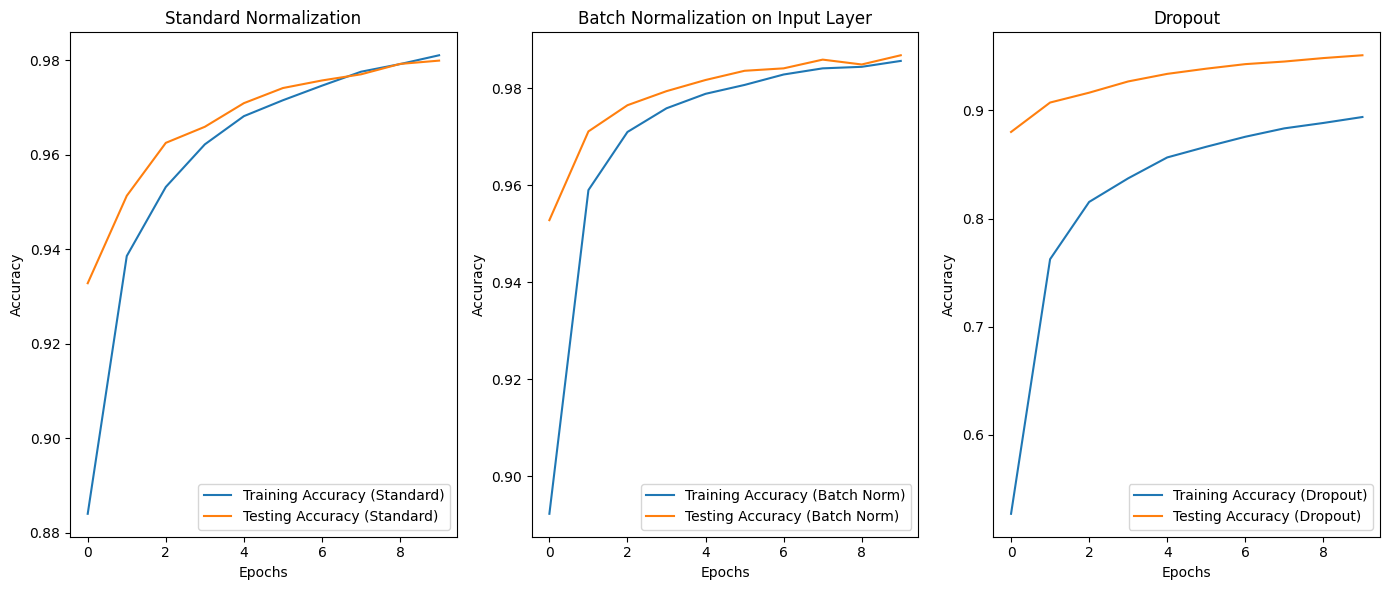

In [18]:
# For plotting all three experiments together:
plt.figure(figsize=(14, 6))
plt.ylim(0.8,1)
# Plotting for Standard Normalization
plt.subplot(1, 3, 1)
plt.plot(train_acc_standard, label='Training Accuracy (Standard)')
plt.plot(test_acc_standard, label='Testing Accuracy (Standard)')
plt.title('Standard Normalization')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting for Batch Normalization on Input Layer
plt.subplot(1, 3, 2)
plt.plot(train_acc_batch, label='Training Accuracy (Batch Norm)')
plt.plot(test_acc_batch, label='Testing Accuracy (Batch Norm)')
plt.title('Batch Normalization on Input Layer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting for Dropout
plt.subplot(1, 3, 3)
plt.plot(train_acc_dropout, label='Training Accuracy (Dropout)')
plt.plot(test_acc_dropout, label='Testing Accuracy (Dropout)')
plt.title('Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Answer:**

1) **Standard Normalization:**
   - Training accuracy increases gradually over epochs.
   - Testing accuracy also increases but starts to level off after 6 epochs.
   - There's a noticeable gap between training and testing accuracy, which indicates some/slight overfitting.

2) **Batch Normalization on Input Layer:**
   - Both the training and testing accuracy increase steadily over epochs.
   - The gap between training and testing accuracy is smaller compared to the standard normalization, suggesting overfitting has reduced.
   - The testing accuracy achieved is slightly higher than with standard normalization.

3) **Dropout:**
   - The training accuracy starts much lower but increases steadily over epochs.
   - For the testing accuracy, it appears that dropout introduces a regularization effect as the training accuracy starts lower compared to the other methods.

While batch normalization seems to offer benefits in reducing overfitting and increasing testing accuracy, the dropout graph shows a lower starting point of the training accuracy line and slower progression. This suggests that dropout introduced regularization, which could help in reducing overfitting.

## 4.5

In [12]:
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
def create_bn_dropout_model():
    model2 = Sequential([
        BatchNormalization(input_shape=(28, 28, 1)),
        Conv2D(6, (5, 5), activation='tanh'),
        AveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Conv2D(16, (5, 5), activation='tanh'),
        AveragePooling2D(),
        BatchNormalization(),
        Dropout(0.5),
        Flatten(),
        Dense(120, activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(84, activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model2

model_bn_dropout = create_bn_dropout_model()

In [13]:
def compile_and_train(model2, epochs=10):
    model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history2 = model2.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=epochs)
    return history2

#dropout_history = compile_and_train(model_dropout)
#bn_history = compile_and_train(model_batch_norm)
bn_dropout_history = compile_and_train(model_bn_dropout)


Epoch 1/10
1875/1875 [==============================] - 42s 22ms/step - loss: 1.0760 - accuracy: 0.6493 - val_loss: 0.2956 - val_accuracy: 0.9125
Epoch 2/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.6008 - accuracy: 0.8079 - val_loss: 0.1958 - val_accuracy: 0.9415
Epoch 3/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.4713 - accuracy: 0.8524 - val_loss: 0.1524 - val_accuracy: 0.9529
Epoch 4/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.4086 - accuracy: 0.8740 - val_loss: 0.1303 - val_accuracy: 0.9611
Epoch 5/10
1875/1875 [==============================] - 40s 22ms/step - loss: 0.3702 - accuracy: 0.8876 - val_loss: 0.1251 - val_accuracy: 0.9634
Epoch 6/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3482 - accuracy: 0.8953 - val_loss: 0.1127 - val_accuracy: 0.9654
Epoch 7/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.3218 - accuracy: 0.9041 - val_loss: 0.1116 -

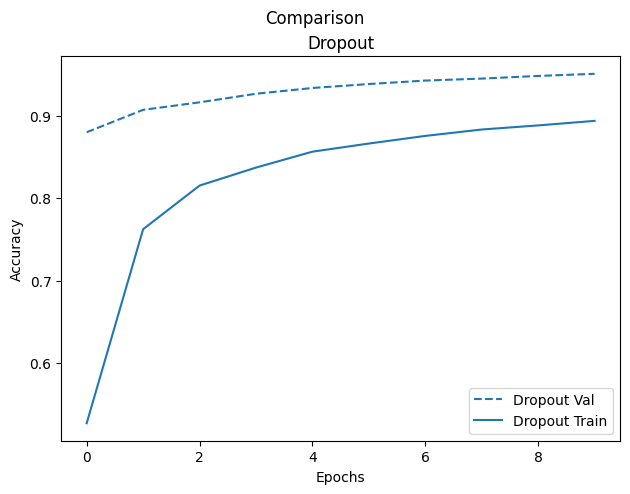

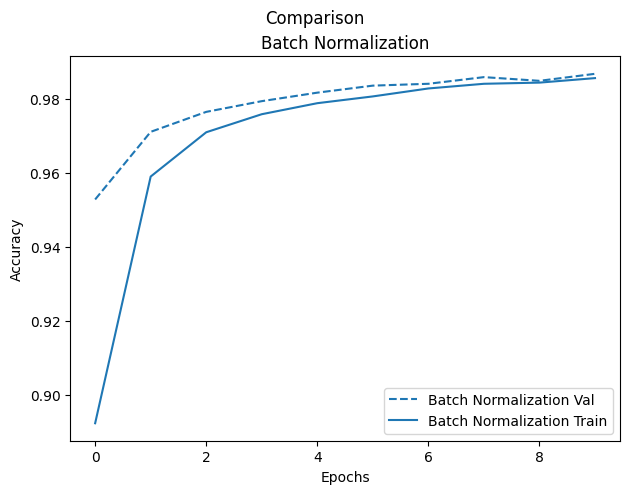

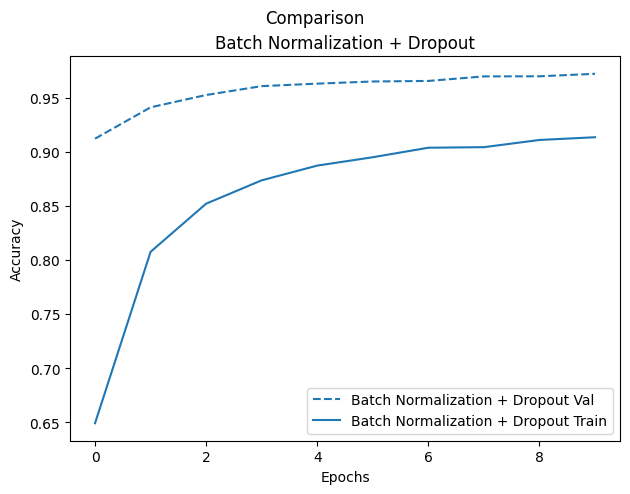

In [14]:
import matplotlib.pyplot as plt

def plot_history_subplots(histories, title):
    #plt.figure(figsize=(15,6))

    # Iterate through the histories and create subplots for each
    for idx, (name, history) in enumerate(histories):
        #plt.subplot(3, 2, idx + 1)
        val = plt.plot(history.epoch, history.history['val_accuracy'], '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history['accuracy'], color=val[0].get_color(), label=name.title()+' Train')

        plt.title(name.title())
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()

        plt.suptitle(title, y=1.02)
        plt.show()

plot_history_subplots([('dropout', history_dropout),
                       ('batch normalization', history_batch_norm),
                       ('batch normalization + dropout', bn_dropout_history)],
                      'Comparison')

**Answer:**

- Batch normalization has greatly accelerated training and achieved higher performance than dropout alone. However, it showed signs of slight overfitting.
- Dropout, acting as a regularizer, reduced overfitting but led to a drop in performance.
- Using both batch normalization and dropout together seems to provide a good balance. The combination achieves better performance than using dropout alone, with reduced overfitting compared to batch normalization alone.